<a href="https://colab.research.google.com/github/GulsumSayin/wifi-csi-har/blob/main/csi_har.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Veri Setinin Model Girişine Uygun Hale Getirilmesi**

In [ ]:
# Veri seti yolunu ayarlama
root = "/content/drive/MyDrive/wifi_csi_har_dataset"

In [ ]:
import os
import pandas as pd
import numpy as np

def load_dataset(root):
    all_data, all_labels = [], []

    for room in os.listdir(root):
        room_path = os.path.join(root, room)
        if not os.path.isdir(room_path):
            continue
        for sub in os.listdir(room_path):
            sub_path = os.path.join(room_path, sub)
            data_file = os.path.join(sub_path, "data.csv")
            label_file = os.path.join(sub_path, "label.csv")

            if os.path.exists(data_file) and os.path.exists(label_file):
                # data.csv içeriğini al
                data = pd.read_csv(data_file).values
                # label.csv'nin sadece 2. sütununu (etiket) al
                labels = pd.read_csv(label_file, usecols=[1]).values.ravel()

                all_data.append(data)
                all_labels.append(labels)

    X = np.vstack(all_data)
    y = np.hstack(all_labels).astype(str)  # hepsi string olsun
    return X, y

# Kullanım
X, y = load_dataset(root)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Benzersiz etiketler:", np.unique(y))

X shape: (67439, 1026)
y shape: (67429,)
Benzersiz etiketler: ['get_down' 'get_up' 'lying' 'no_person' 'sitting' 'standing' 'walking']


Toplam örnek sayısı: 67429

Sınıf get_down: 2750 örnek, %4.08
Sınıf get_up: 2495 örnek, %3.70
Sınıf lying: 7400 örnek, %10.97
Sınıf no_person: 8620 örnek, %12.78
Sınıf sitting: 9340 örnek, %13.85
Sınıf standing: 7380 örnek, %10.94
Sınıf walking: 29444 örnek, %43.67


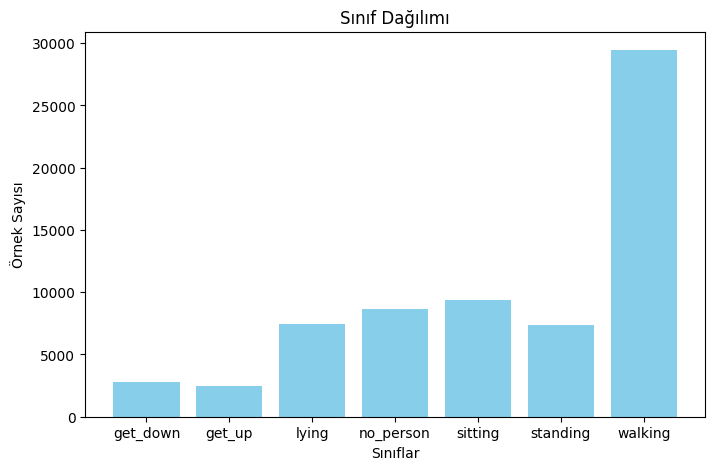

In [ ]:
import numpy as np
import pandas as pd

# y zaten yüklenmiş
unique, counts = np.unique(y, return_counts=True)
total = len(y)

print(f"Toplam örnek sayısı: {total}\n")
for cls, cnt in zip(unique, counts):
    print(f"Sınıf {cls}: {cnt} örnek, %{cnt/total*100:.2f}")

# Görselleştirme (opsiyonel)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar([str(u) for u in unique], counts, color='skyblue')
plt.xlabel("Sınıflar")
plt.ylabel("Örnek Sayısı")
plt.title("Sınıf Dağılımı")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)
num_classes = len(le.classes_)
print("Sınıflar:", le.classes_)

Sınıflar: ['get_down' 'get_up' 'lying' 'no_person' 'sitting' 'standing' 'walking']


In [ ]:
# CSI reshape
total_samples = (X.shape[0] // 114) * 114  # tam bölünecek sayı
X = X[:total_samples].reshape(-1, 114, 9, 1)
print("Yeni X shape:", X.shape)

Yeni X shape: (67374, 114, 9, 1)


In [ ]:
# X ve y dizinlerini eşleştirmek
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]

print("Yeni boyutlar:", X.shape, y.shape)

Yeni boyutlar: (67374, 114, 9, 1) (67374,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Encode y_train and y_test
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

y_train_cat shape: (53899, 7)
y_test_cat shape: (13475, 7)


In [ ]:
# 4. Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights)

Class Weights: {0: 3.499935064935065, 1: 3.857643859146865, 2: 1.3006515444015443, 3: 1.116568611203182, 4: 1.0304947996329152, 5: 1.31396879570941, 6: 0.3268884373957607}


**Model**

In [ ]:
import tensorflow as tf

num_classes = 7

model = tf.keras.Sequential([
    # 1. CNN katmanları (özellik çıkarma)
    tf.keras.layers.Conv2D(32, (3,3), padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                           input_shape=(114, 9, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # Flatten the output for dense layers
    tf.keras.layers.Flatten(),

    # 3. Dense katmanlar
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Loss + optimizer
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 114, 9, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 114, 9, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 114, 9, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 57, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 57, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 57, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 57, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 2, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 2, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 28, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,103 (3.86 MB)

 Trainable params: 1,011,655 (3.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callback'ler

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


# Eğitim

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 180s 105ms/step - accuracy: 0.4996 - loss: 1.4722 - val_accuracy: 0.6957 - val_loss: 0.9962 - learning_rate: 1.0000e-04
Epoch 2/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 201s 104ms/step - accuracy: 0.6601 - loss: 1.0458 - val_accuracy: 0.7383 - val_loss: 0.8103 - learning_rate: 1.0000e-04
Epoch 3/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 173s 103ms/step - accuracy: 0.7103 - loss: 0.8948 - val_accuracy: 0.7676 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 4/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 201s 102ms/step - accuracy: 0.7412 - loss: 0.8052 - val_accuracy: 0.7898 - val_loss: 0.6754 - learning_rate: 1.0000e-04
Epoch 5/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 172s 102ms/step - accuracy: 0.7599 - loss: 0.7536 - val_accuracy: 0.8028 - val_loss: 0.6333 - learning_rate: 1.0000e-04
Epoch 6/100
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 203s 103ms/step - accuracy: 0.7739 - loss: 0.7096 - val_accuracy: 0.8232 - val_loss: 0.5983 - learning_rate: 1.0000e-04
Epoch 7/100
1685/1685 

**Modelin Kaydedilmesi**

In [ ]:
model.save("/content/drive/MyDrive/csi_har.h5")

In [ ]:
model.save("/content/drive/MyDrive/csi_har_model.keras")

**Model eğitimi sonucu elde edilen eğitim ve validasyon sonuçlarının grafiksel olarak elde edilmesi**

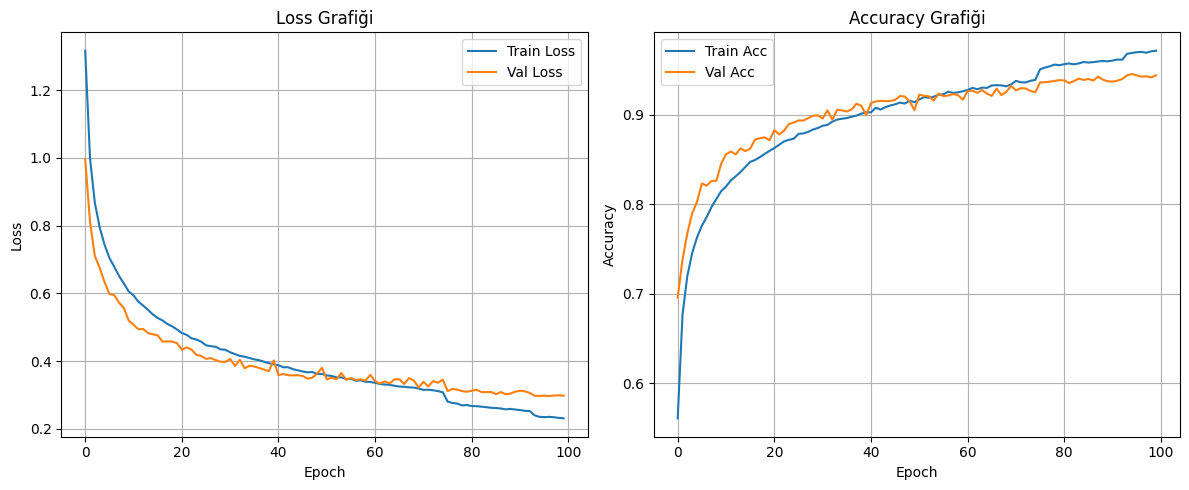

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Modelin Test Edilmesi**

In [25]:
# Test seti ile model değerlendirmesi
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9434 - loss: 0.2952
Test Accuracy: 0.9426


In [26]:
y_pred_probs = model.predict(X_test)        # Her sınıf için olasılık
y_pred = np.argmax(y_pred_probs, axis=1)    # En yüksek olasılıklı sınıfı al
y_pred_labels = le.inverse_transform(y_pred) # Orijinal etiketlere çevir

422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

[[ 373    7    7    3   13   19  128]
 [  32  317   57    2   54    0   37]
 [   1    6 1455    5    4    0    9]
 [   0    0    1 1680    1    0   42]
 [   9    8    0    0 1826    4   21]
 [   3    0    0    2    8 1349  103]
 [  19    8    5   28   14  113 5702]]
              precision    recall  f1-score   support

    get_down       0.85      0.68      0.76       550
      get_up       0.92      0.64      0.75       499
       lying       0.95      0.98      0.97      1480
   no_person       0.98      0.97      0.98      1724
     sitting       0.95      0.98      0.96      1868
    standing       0.91      0.92      0.91      1465
     walking       0.94      0.97      0.96      5889

    accuracy                           0.94     13475
   macro avg       0.93      0.88      0.90     13475
weighted avg       0.94      0.94      0.94     13475

